## Import Libs

In [1]:
# import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from torch.optim import AdamW
from utils import SklearnWrapper

In [2]:
from config import *
from entities import *
from components import *
from strategies import *
from datasets import *
from engine import Engine
from models import DiffusionTransformer
from frameworks import Diffusion

## Setting 

In [3]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Data

### Load Data to basket

In [4]:
symbols = ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'GOOG', 'META', 'AVGO', 'ORCL', 'CRM', 'ADBE', 'AMD', 'CSCO']
basket = Basket(symbols=symbols)
basket.load_all_assets(freq="1d")

DEBUG:entities.basket:Initialized Asset Basket: ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'GOOG', 'META', 'AVGO', 'ORCL', 'CRM', 'ADBE', 'AMD', 'CSCO'] with 0 assets which loaded.
INFO:entities.basket:Starting batch load for 14 symbols...
DEBUG:entities.basket:Attempting to load AAPL...
DEBUG:entities.asset:Initialized Asset: AAPL with 2724 rows.
INFO:entities.basket:Successfully loaded AAPL (2724 rows).
DEBUG:entities.basket:Attempting to load TSLA...
DEBUG:entities.asset:Initialized Asset: TSLA with 2760 rows.
INFO:entities.basket:Successfully loaded TSLA (2760 rows).
DEBUG:entities.basket:Attempting to load MSFT...
DEBUG:entities.asset:Initialized Asset: MSFT with 2724 rows.
INFO:entities.basket:Successfully loaded MSFT (2724 rows).
DEBUG:entities.basket:Attempting to load NVDA...
DEBUG:entities.asset:Initialized Asset: NVDA with 2724 rows.
INFO:entities.basket:Successfully loaded NVDA (2724 rows).
DEBUG:entities.basket:Attempting to load GOOGL...
DEBUG:entities.asset:Initia

### Norm To Returns

In [5]:
targets = ["Close"]
for symbol, asset in basket.assets.items():
    asset.to_returns(log=True, columns=targets)
asset.data.head(5)

DEBUG:entities.asset:AAPL converted to Returns (log=True)
DEBUG:entities.asset:TSLA converted to Returns (log=True)
DEBUG:entities.asset:MSFT converted to Returns (log=True)
DEBUG:entities.asset:NVDA converted to Returns (log=True)
DEBUG:entities.asset:GOOGL converted to Returns (log=True)
DEBUG:entities.asset:AMZN converted to Returns (log=True)
DEBUG:entities.asset:GOOG converted to Returns (log=True)
DEBUG:entities.asset:META converted to Returns (log=True)
DEBUG:entities.asset:AVGO converted to Returns (log=True)
DEBUG:entities.asset:ORCL converted to Returns (log=True)
DEBUG:entities.asset:CRM converted to Returns (log=True)
DEBUG:entities.asset:ADBE converted to Returns (log=True)
DEBUG:entities.asset:AMD converted to Returns (log=True)
DEBUG:entities.asset:CSCO converted to Returns (log=True)


,High,Low,Open,Volume,Close (Log_Returns)
Date,,,,,
2015-01-05,19.700776,19.377812,19.607475,29460600,-0.020121
2015-01-06,19.865848,19.406522,19.478291,47297600,-0.000370
2015-01-07,19.664896,19.363463,19.478295,27570800,0.009200
2015-01-08,20.160107,19.715135,19.765374,40907000,0.007663
2015-01-09,20.145750,19.700779,19.858671,33619600,0.010127


### Align Data (Joint Data)

In [6]:
strategy = IntersectionStrategy()
joint_df = basket.align(strategy)
joint_df.head()

DEBUG:strategies.concrete:Intersection Strategy: Aligned 14 assets. Common rows: 1463
DEBUG:entities.basket:Aligned data shape: (1463, 70)
INFO:entities.basket:Assets updated in-place to aligned index (Length: 1463)


AAPL                                                       \
                 High        Low       Open     Volume Close (Log_Returns)   
Date                                                                         
2020-01-03  72.594055  71.608685  71.765667  146322800           -0.009770   
2020-01-06  72.444344  70.703034  70.954210  118387200            0.007937   
2020-01-07  72.671341  71.845369  72.415337  108872000           -0.004715   
2020-01-08  73.526310  71.768094  71.768094  132079200            0.015958   
2020-01-09  74.972955  73.951358  74.202527  170108400            0.021018   

                 TSLA                                                       \
                 High        Low       Open     Volume Close (Log_Returns)   
Date                                                                         
2020-01-03  30.266666  29.128000  29.366667  266677500            0.029203   
2020-01-06  30.104000  29.333332  29.364668  151995000            0.019072   
2020-01-07  31.441999  30.224001  30.760000  268231500            0.038067   
2020-01-08  33.232666  31.215334  31.580000  467164500            0.048033   
2020-01-09  33.253334  31.524668  33.139999  426606000           -0.022189   

            ...        AMD                                  \
            ...       High        Low       Open    Volume   
Date        ...                                              
2020-01-03  ...  49.389999  47.540001  48.029999  73127400   
2020-01-06  ...  48.860001  47.860001  48.020000  47934900   
2020-01-07  ...  49.389999  48.040001  49.349998  58061400   
2020-01-08  ...  48.299999  47.139999  47.849998  53767000   
2020-01-09  ...  49.959999  48.389999  48.939999  76512800   

                                     CSCO                                  \
           Close (Log_Returns)       High        Low       Open    Volume   
Date                                                                        
2020-01-03           -0.010236  40.453623  39.899004  40.260347  15577400   
2020-01-06           -0.004330  40.184715  39.504044  39.613288  22183600   
2020-01-07           -0.002897  40.100678  39.579670  40.100678  16501900   
2020-01-08           -0.008743  40.159507  39.335982  39.470435  25175900   
2020-01-09            0.023555  40.235133  39.554462  40.159503  18203600   

                                
           Close (Log_Returns)  
Date                            
2020-01-03           -0.016450  
2020-01-06            0.003563  
2020-01-07           -0.006507  
2020-01-08            0.000632  
2020-01-09           -0.004218  

[5 rows x 70 columns]

In [7]:
features = ["Close (Log_Returns)"]
basket_tensor = basket.to_tensor(features=features)
basket_tensor.shape

DEBUG:entities.asset:Asset: AAPL is using cuda device.
DEBUG:entities.asset:Asset: TSLA is using cuda device.
DEBUG:entities.asset:Asset: MSFT is using cuda device.
DEBUG:entities.asset:Asset: NVDA is using cuda device.
DEBUG:entities.asset:Asset: GOOGL is using cuda device.
DEBUG:entities.asset:Asset: AMZN is using cuda device.
DEBUG:entities.asset:Asset: GOOG is using cuda device.
DEBUG:entities.asset:Asset: META is using cuda device.
DEBUG:entities.asset:Asset: AVGO is using cuda device.
DEBUG:entities.asset:Asset: ORCL is using cuda device.
DEBUG:entities.asset:Asset: CRM is using cuda device.
DEBUG:entities.asset:Asset: ADBE is using cuda device.
DEBUG:entities.asset:Asset: AMD is using cuda device.
DEBUG:entities.asset:Asset: CSCO is using cuda device.


torch.Size([1463, 14, 1])

In [8]:
def verify_scaling(t: torch.Tensor):
    print(f"Max: {t.max().item():.4f}")
    print(f"Min: {t.min().item():.4f}")
    print(f"Mean: {t.mean().item():.4f}")
    print(f"Std: {t.std().item():.4f}")

verify_scaling(basket_tensor)

Max: 0.3071
Min: -0.3064
Mean: 0.0010
Std: 0.0263


#### Market Setup & Window Rolling Setup

In [9]:
window = RollingWindow(size=64, stride=1)
market = Market(basket, window)
market_tensor = market.setup(features=features)

INFO:entities.market:Setting up Market environment
DEBUG:entities.asset:Asset: AAPL is using cuda device.
DEBUG:entities.asset:Asset: TSLA is using cuda device.
DEBUG:entities.asset:Asset: MSFT is using cuda device.
DEBUG:entities.asset:Asset: NVDA is using cuda device.
DEBUG:entities.asset:Asset: GOOGL is using cuda device.
DEBUG:entities.asset:Asset: AMZN is using cuda device.
DEBUG:entities.asset:Asset: GOOG is using cuda device.
DEBUG:entities.asset:Asset: META is using cuda device.
DEBUG:entities.asset:Asset: AVGO is using cuda device.
DEBUG:entities.asset:Asset: ORCL is using cuda device.
DEBUG:entities.asset:Asset: CRM is using cuda device.
DEBUG:entities.asset:Asset: ADBE is using cuda device.
DEBUG:entities.asset:Asset: AMD is using cuda device.
DEBUG:entities.asset:Asset: CSCO is using cuda device.
DEBUG:components.windowing:RollingWindow applied. Result: torch.Size([1400, 64, 14, 1])
INFO:entities.market:Market Setup Complete. Batch Shape: torch.Size([1400, 64, 14, 1]) [B, L

In [10]:
print(f"Market Tensor Shape: {market_tensor.shape}")
verify_scaling(market_tensor)

Market Tensor Shape: torch.Size([1400, 64, 14, 1])
Max: 0.3071
Min: -0.3064
Mean: 0.0010
Std: 0.0261


### Scaler

In [11]:
sklearn_scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = SklearnWrapper(sklearn_scaler)

scaler.fit(market_tensor)
norm_data = scaler.encode(market_tensor)

print(f"Norm data shape: {market_tensor.shape}")
print(f"Data {market_tensor[0,0,0,:]}")
verify_scaling(norm_data)

DEBUG:utils.scaler:Scaler Fitted using: MinMaxScaler


Norm data shape: torch.Size([1400, 64, 14, 1])
Data tensor([-0.0098], device='cuda:0')
Max: 1.0000
Min: -1.0000
Mean: 0.0021
Std: 0.0852


### Dataloader & Datasets

In [12]:
modes = ["exhaustive", "random"]
market_ds = JointMarketDataset(norm_data)

print(f"Norm Data: {norm_data.shape}")
print(f"Market Dataset: {len(market_ds)}")

# market_ds = MarketDataset(norm_data, mode='random')
ratios = [0.8, 0.1, 0.1]
train_ds, val_ds, test_ds = create_randomize_datasets(market_ds, ratios)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}") 
print(f"Test samples: {len(test_ds)}")

Norm Data: torch.Size([1400, 64, 14, 1])
Market Dataset: 1400
Train samples: 1120
Val samples: 140
Test samples: 140


In [13]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [14]:
x = next(iter(train_loader))
print(f"x shape: {x.shape}")
verify_scaling(x)

x shape: torch.Size([32, 64, 14, 1])
Max: 0.6048
Min: -0.7251
Mean: -0.0021
Std: 0.1558


## Model

### Setup

In [15]:
cfg = TrainConfig(
    epochs=10000,
    optimizer=OptimizerConfig(lr=2e-4)
)

print(cfg.optimizer.lr) 
print(cfg.epochs)    
print(cfg.ddpm)

0.0002
10000
DDPMConfig(noise_steps=1000, beta_start=0.0001, beta_end=0.02, schedule='cosine', d_model=128, n_heads=4, n_layers=4, max_t=128)


In [16]:
WINDOW_SIZE = x.shape[1]       # T
NUM_ASSETS = x.shape[2]         # N
NUM_FEATURES = x.shape[3]      # F
TOTAL_INPUT_DIM = NUM_ASSETS * NUM_FEATURES # C = N * F (Flatten)

print(f"Running on: {cfg.device}")
print(f"Input Dimension (Channels): {TOTAL_INPUT_DIM}")

Running on: cuda
Input Dimension (Channels): 14


### Diffusion

In [17]:
diffusion = Diffusion(
    noise_steps=cfg.ddpm.noise_steps,
    beta_start=cfg.ddpm.beta_start,
    beta_end=cfg.ddpm.beta_end,
    schedule=cfg.scheduler.type,
    device=cfg.device
)

DEBUG:frameworks.ddpm:Diffusion is using cosine schedule.


### NN Model

In [18]:
model = DiffusionTransformer(
    features_in=TOTAL_INPUT_DIM,  # รับ Input ขนาด N*F
    d_model=cfg.ddpm.d_model,                  # ความกว้าง Model
    nhead=cfg.ddpm.n_heads,
    num_layers=cfg.ddpm.n_layers,
    max_len=WINDOW_SIZE           # รองรับความยาวสูงสุดเท่า Window
).to(cfg.device)

/home/narodom.y@FUSION.LAB/.conda/envs/tsgenai/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Optimizer

In [19]:
optimizer = AdamW(model.parameters(), lr=cfg.optimizer.lr, weight_decay=cfg.optimizer.weight_decay)

## Engine

In [20]:
engine = Engine(
    model=model,
    diffusion=diffusion,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    device=cfg.device,
    scaler=scaler
)

### Training

In [21]:
engine.fit(epochs=cfg.epochs, save_dir="./checkpoints")

INFO:engine.trainer:Engine started Training for 10000 epochs on cuda...
Epoch 7669/10000:  14%|█▍        | 5/35 [00:00<00:00, 49.60it/s, loss=0.0307]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 8236/10000:  86%|████████▌ | 30/35 [00:00<00:00, 50.78it/s, loss=0.0294]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 9629/10000:   0%|          | 0/35 [00:00<?, ?it/s, loss=0.0385]IOPub message rate exceeded.
The Jupyter server will temporarily sto

### Test

In [22]:
x_test = next(iter(test_loader))
x_test.shape

torch.Size([32, 64, 14, 1])

In [23]:
verify_scaling(x_test)

Max: 0.7534
Min: -1.0000
Mean: 0.0029
Std: 0.0867


In [24]:
prediction = engine.simulate(x_test, steps_to_predict=8)
prediction.shape

INFO:engine.trainer:Simulating... (Masking last 8 steps)
In-painting: 1000it [00:04, 231.70it/s]


(32, 64, 14, 1)

In [25]:
verify_scaling(prediction)

Max: 0.7534
Min: -1.0000
Mean: 0.0034
Std: 0.0855


## Monte Carlo Sim (GenAI)

In [26]:
@torch.no_grad()
def monte_carlo_simulate(context_data, steps_to_simulate, engine,num_simulations=100):
    x_context = context_data.repeat(num_simulations, 1, 1, 1).to(engine.device)
    mc_results = engine.simulate(x_context, steps_to_simulate)
    return mc_results

In [27]:
x_test_sampling = x_test[0].unsqueeze(0)
x_test_sampling.shape

torch.Size([1, 64, 14, 1])

In [28]:
mc_y = monte_carlo_simulate(context_data=x_test_sampling, steps_to_simulate=24, engine=engine,num_simulations=100)
mc_y.shape # [Sims, Time, Assets, Features]

INFO:engine.trainer:Simulating... (Masking last 24 steps)
In-painting: 1000it [00:05, 188.43it/s]


(100, 64, 14, 1)

## Monete Carlo Statistic

In [29]:
def gbm_monte_carlo_simulate(hist_log_returns: np.ndarray, steps_to_predict: int, num_sims: int = 100, dt: float = 1.0):
    """ Arg: 
            dt: Time increment
        Returns: 
            future_prices: [num_sims, steps_to_predict]
    """
    mu = np.mean(hist_log_returns)
    sigma = np.std(hist_log_returns)

    # Random Shock (Z) from Normal Dist (0, 1) -> shape: [num_sims, steps_to_predict]
    Z = np.random.normal(0, 1, (num_sims, steps_to_predict))

    # Future log returns (GBM)
    # r_t = (mu - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z
    drift_term = (mu - 0.5 * sigma**2) * dt
    shock_term = sigma * np.sqrt(dt) * Z

    future_daily_log_returns = drift_term + shock_term
    cum_log_returns = np.cumsum(future_daily_log_returns, axis=1)

    # future_prices = last_price * np.exp(cum_log_returns)
    
    return future_daily_log_returns

In [30]:
x_test_sampling.shape

torch.Size([1, 64, 14, 1])

In [31]:
x_test_statistic_sampling = x_test_sampling[0,:,:,:]
x_test_statistic_sampling.shape

torch.Size([64, 14, 1])

In [32]:
x_test_statistic_sampling = x_test_statistic_sampling[:,0,0]
x_test_statistic_sampling.shape

torch.Size([64])

In [33]:
type(x_test_statistic_sampling)

torch.Tensor

In [34]:
mc_paths = gbm_monte_carlo_simulate(
    hist_log_returns=x_test_statistic_sampling.cpu().numpy(), 
    steps_to_predict=14, 
    num_sims=1000
)
type(mc_paths)

numpy.ndarray

In [35]:
asset_tests = x_test_sampling[0, :,:, :]
asset_tests.shape

torch.Size([64, 14, 1])

In [36]:
asset_tests = asset_tests.permute(1,0,2)
asset_tests.shape

torch.Size([14, 64, 1])

In [37]:
mc_simed_ret_assets = []
for asset in asset_tests:
    mc_sim_ret = gbm_monte_carlo_simulate(
        hist_log_returns=asset[:, 0].cpu().numpy(), 
        steps_to_predict=14, 
        num_sims=1000
    )
    mc_simed_ret_assets.append(mc_sim_ret)

In [38]:
len(mc_simed_ret_assets)

14

In [39]:
for asset in mc_simed_ret_assets:
    mc_ret_context = asset[:, -1]
    mc_ret_sim = asset[-1, :]

    mean_ret_sim = np.mean(mc_ret_sim)
    std_ret_sim = np.std(mc_ret_sim)
    upper_bound = np.percentile(mc_ret_sim, 95) # Best case 5%
    lower_bound = np.percentile(mc_ret_sim, 5) # Worst case 5%
    print(f"mean: {mean_ret_sim}, std: {std_ret_sim}")
    print(f"lower bound: {lower_bound}, upper bound:{upper_bound}")

mean: 0.002491280837437757, std: 0.08141816507859992
lower bound: -0.1252065970692252, upper bound:0.10483787847538428
mean: 0.04716399162746091, std: 0.10936617481394569
lower bound: -0.11293988520344413, upper bound:0.1845300599346691
mean: -0.012204400285022485, std: 0.03539453197413641
lower bound: -0.06170342043078813, upper bound:0.04110536303782341
mean: -0.0007115863467340633, std: 0.047569639485703086
lower bound: -0.07548524584718386, upper bound:0.06048306215666034
mean: -0.004862042215274051, std: 0.04969240564477675
lower bound: -0.06484472568901019, upper bound:0.0772373421422919
mean: -0.021368856465613855, std: 0.059578225264141624
lower bound: -0.10077731825207402, upper bound:0.06878581308903141
mean: -0.011499687616607463, std: 0.05599845564963771
lower bound: -0.10940968500214636, upper bound:0.05742788708742507
mean: -0.04428694703068197, std: 0.06728134535336518
lower bound: -0.1596704680788574, upper bound:0.04995866440779526
mean: -0.010277519310936147, std: 0.0

Correlation Matrix:
[[ 1.00000000e+00 -3.58463846e-02  1.88759744e-02  3.41571748e-02
   2.66954313e-02  2.78027950e-02 -3.86282760e-02  4.00300163e-02
   5.63335148e-02 -2.96361808e-02  1.41270441e-03  1.07710915e-02
  -5.81165880e-02  1.85740780e-02]
 [-3.58463846e-02  1.00000000e+00 -1.19901559e-02 -1.00175528e-02
  -9.23696902e-03 -1.98877877e-02 -5.00104792e-03 -3.02605061e-02
   1.05330307e-02 -1.19506156e-02  2.70976712e-02 -2.01694642e-02
  -8.80831577e-03  2.20235190e-02]
 [ 1.88759744e-02 -1.19901559e-02  1.00000000e+00 -3.38911836e-02
  -1.95395155e-02 -3.97201522e-02  2.33402387e-02 -1.04229684e-02
  -2.59397170e-02 -1.23440282e-02 -1.27085493e-02 -3.60418869e-03
  -6.73065283e-03 -3.83781086e-02]
 [ 3.41571748e-02 -1.00175528e-02 -3.38911836e-02  1.00000000e+00
  -2.24242792e-02 -2.81002446e-02  4.52738417e-02 -1.35548015e-02
   2.44772743e-02 -1.20878659e-02  9.01888078e-03  3.96628848e-03
   3.90561769e-02  1.95297290e-02]
 [ 2.66954313e-02 -9.23696902e-03 -1.95395155e-0

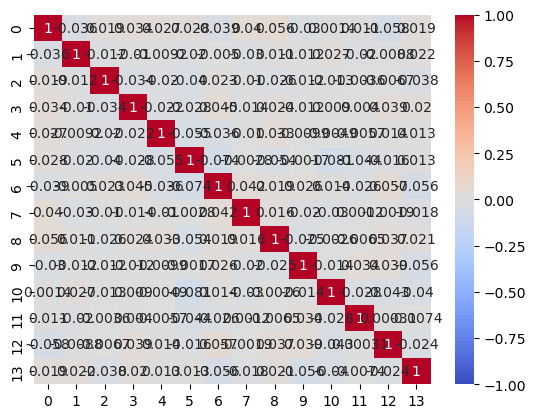

In [40]:
sim_results_per_asset = []

for asset_sim in mc_simed_ret_assets:
    # asset_sim shape: (1000, 14) -> Daily Log Returns
    
    # รวม Log Return 14 วัน เป็นก้อนเดียว (Total Log Return)
    # axis=1 คือรวมตามแกนเวลา (Time)
    total_return = np.sum(asset_sim, axis=1) # ได้ shape (1000,)
    
    sim_results_per_asset.append(total_return)

# 2. แปลงเป็น Matrix (Num_Assets, Num_Sims)
# เช่น (3, 1000)
comparison_matrix = np.array(sim_results_per_asset)

# 3. คำนวณ Correlation Matrix
corr_matrix = np.corrcoef(comparison_matrix)

print("Correlation Matrix:")
print(corr_matrix)

# (แถม) วาด Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## Experiment

### Ground Truth Stats

In [41]:
x_test = next(iter(test_loader))
x_test_sampling = x_test[2, :, :, :]
x_test_sampling.shape

torch.Size([64, 14, 1])

In [42]:
x_test_sampling_np = x_test_sampling.cpu().numpy()
print(type(x_test_sampling))
print(type(x_test_sampling_np))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


In [43]:
def calc_stats(x):
    if x.ndim == 2:
        # Shape: [64, 3] -> [L, N]
        print(x.shape)
        mean = np.mean(x, axis=0)
        std = np.std(x, axis=0)
        avg_corr = np.corrcoef(x.T)

    # Calc All na
    if x.ndim == 3:
        # Shape: (1000, 64, 3) -> [Num of sims, L, N]
        mean = np.mean(x, axis=(0, 1))
        std = np.std(x, axis=(0, 1))

        corrs = []
        for i in range(x.shape[0]):
            c_mat = np.corrcoef(x[i].T)
            corrs.append(c_mat)

        avg_corr = np.mean(corrs,axis=0)
    return mean, std, avg_corr

In [44]:
gt_mean, gt_std, gt_corr = calc_stats(x_test_sampling_np[:,:,-1])

(64, 14)


In [45]:
gt_corr

array([[1.        , 0.49994617, 0.76339455, 0.74182204, 0.76441889,
        0.59307952, 0.75594194, 0.47478648, 0.80554683, 0.47062362,
        0.5868092 , 0.7716805 , 0.76857981, 0.70285258],
       [0.49994617, 1.        , 0.29603523, 0.62143085, 0.29743284,
        0.35110409, 0.30179553, 0.10717069, 0.39015915, 0.21294977,
        0.40240044, 0.37097953, 0.49317301, 0.24488883],
       [0.76339455, 0.29603523, 1.        , 0.71016425, 0.88360242,
        0.69936989, 0.88093408, 0.48298566, 0.70346077, 0.44666081,
        0.54760454, 0.72716539, 0.72134122, 0.61236923],
       [0.74182204, 0.62143085, 0.71016425, 1.        , 0.63200046,
        0.63877197, 0.63468033, 0.32805516, 0.7114327 , 0.42712361,
        0.58375794, 0.69944516, 0.88780137, 0.55551397],
       [0.76441889, 0.29743284, 0.88360242, 0.63200046, 1.        ,
        0.70370861, 0.99844608, 0.53834628, 0.62727151, 0.38440606,
        0.55949889, 0.74048807, 0.6736865 , 0.51475072],
       [0.59307952, 0.35110409, 0.6

In [46]:
print("--- Ground Truth Stats ---")
print(f"Mean: {gt_mean}")
print(f"Std:  {gt_std}")
print(f"Corr Matrix:\n{gt_corr}")
print("-" * 30)

--- Ground Truth Stats ---
Mean: [-0.00321257 -0.02668866 -0.00066025  0.01917933 -0.00257902 -0.01030797
 -0.00224085  0.00129004  0.01311105  0.01245    -0.00193173  0.00880866
  0.00853048  0.00498141]
Std:  [0.0785631  0.14800541 0.07917162 0.11965352 0.08599364 0.09739576
 0.0877514  0.15336393 0.0709594  0.05133785 0.09695854 0.08073133
 0.10755908 0.04774885]
Corr Matrix:
[[1.         0.49994617 0.76339455 0.74182204 0.76441889 0.59307952
  0.75594194 0.47478648 0.80554683 0.47062362 0.5868092  0.7716805
  0.76857981 0.70285258]
 [0.49994617 1.         0.29603523 0.62143085 0.29743284 0.35110409
  0.30179553 0.10717069 0.39015915 0.21294977 0.40240044 0.37097953
  0.49317301 0.24488883]
 [0.76339455 0.29603523 1.         0.71016425 0.88360242 0.69936989
  0.88093408 0.48298566 0.70346077 0.44666081 0.54760454 0.72716539
  0.72134122 0.61236923]
 [0.74182204 0.62143085 0.71016425 1.         0.63200046 0.63877197
  0.63468033 0.32805516 0.7114327  0.42712361 0.58375794 0.69944516


### MC Stats

In [47]:
length , num_assets, num_features = x_test_sampling.shape

# Config
SPLIT_IDX = 60
STEPS_SIMS = 4
NUM_SIMS = 5000


In [48]:
x_test_sampling.shape

torch.Size([64, 14, 1])

In [49]:
y = x_test_sampling[-4:]
y.shape

torch.Size([4, 14, 1])

In [50]:
context_data = x_test_sampling[:SPLIT_IDX, :]
context_data.shape

torch.Size([60, 14, 1])

In [51]:
mc_sims_paths = []
for i in range(num_assets):
    print("---" * 30)
    asset_context = context_data[:, i][:, 0]
    print(f"Shape: {asset_context.shape}")
    mc_pred_returns = gbm_monte_carlo_simulate(
        hist_log_returns=asset_context.cpu().numpy(), 
        steps_to_predict=STEPS_SIMS, 
        num_sims=NUM_SIMS
    )
    print(f"MC Pred Returns Shape: {mc_pred_returns.shape}")
    
    context_expanded = np.tile(asset_context.cpu(), (NUM_SIMS, 1))
    print(f"Context Expanded Shape: {context_expanded.shape}")
    
    full_paths = np.hstack([context_expanded, mc_pred_returns])
    print(f"Full Paths Shape: {full_paths.shape}")
    mc_sims_paths.append(full_paths)

------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (5000, 4)
Context Expanded Shape: (5000, 60)
Full Paths Shape: (5000, 64)
------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (5000, 4)
Context Expanded Shape: (5000, 60)
Full Paths Shape: (5000, 64)
------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (5000, 4)
Context Expanded Shape: (5000, 60)
Full Paths Shape: (5000, 64)
------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (5000, 4)
Context Expanded Shape: (5000, 60)
Full Paths Shape: (5000, 64)
------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (5000, 4)
Cont

#### Inside detail in the loop

In [52]:
mc_pred_returns = gbm_monte_carlo_simulate(
    hist_log_returns=asset_context.cpu().numpy(), 
    steps_to_predict=STEPS_SIMS, 
    num_sims=NUM_SIMS
)
mc_pred_returns.shape

(5000, 4)

In [53]:
context_expanded = np.tile(asset_context.cpu(), (NUM_SIMS, 1))
context_expanded.shape

(5000, 60)

In [54]:
full_paths = np.hstack([context_expanded, mc_pred_returns])
full_paths.shape

(5000, 64)

#### MC Stats Calc

In [55]:
mc_sims_paths[0].shape

(5000, 64)

In [56]:
mc_sims = np.stack(mc_sims_paths, axis=-1)
mc_sims.shape

(5000, 64, 14)

In [57]:
type(mc_sims)

numpy.ndarray

In [58]:
mc_sims_mean, mc_sims_std, mc_sims_corr = calc_stats(mc_sims)

In [59]:
print("--- MC Stats ---")
print(f"Mean: {mc_sims_mean}")
print(f"Std:  {mc_sims_std}")
print(f"Corr Matrix:\n{mc_sims_corr}")
print("-" * 30)

--- MC Stats ---
Mean: [-0.00476016 -0.03381146 -0.00107924  0.01719126 -0.00630441 -0.01076179
 -0.00624299 -0.00014634  0.01471712  0.0144377  -0.00292266  0.00737994
  0.009466    0.00768426]
Std:  [0.08055712 0.14711163 0.07966364 0.11837037 0.08543851 0.09863195
 0.08682862 0.15757076 0.07226105 0.05117415 0.09876889 0.081772
 0.10842602 0.04703242]
Corr Matrix:
[[1.         0.46470865 0.72058358 0.70622595 0.72778257 0.55887132
  0.72072551 0.44569882 0.76897944 0.45331366 0.54928539 0.72603211
  0.73184407 0.69679389]
 [0.46470865 1.         0.2597439  0.5679318  0.27213653 0.33959086
  0.27191387 0.10268937 0.38020363 0.21452949 0.38030321 0.34205267
  0.4666529  0.27245782]
 [0.72058358 0.2597439  1.         0.65693524 0.85069026 0.65291593
  0.84814142 0.458618   0.66109445 0.40452744 0.50659182 0.67711501
  0.66965714 0.58480659]
 [0.70622595 0.5679318  0.65693524 1.         0.61582294 0.60655041
  0.61696516 0.32077711 0.67594463 0.39782845 0.55629931 0.6610184
  0.83640672

## MC (GenAI) Stats

In [60]:
# x_test_sampling = x_test[0].unsqueeze(0)
x_test_sampling.shape

torch.Size([64, 14, 1])

In [61]:
length , num_assets, num_features = x_test_sampling.shape

# Config
SPLIT_IDX = 60
STEPS_SIMS = 4
NUM_SIMS = 5000


In [62]:
mc_genai_y = x_test_sampling[-4:]
mc_genai_y.shape

torch.Size([4, 14, 1])

In [63]:
mc_genai_context_x = x_test_sampling[:SPLIT_IDX, :]
mc_genai_context_x.shape

torch.Size([60, 14, 1])

In [64]:
mc_genai_context_x = mc_genai_context_x.unsqueeze(0)
mc_genai_context_x.shape

torch.Size([1, 60, 14, 1])

In [ ]:
# Shape requires [1, 64, 3, 2]
mc_y = monte_carlo_simulate(context_data=mc_genai_context_x, steps_to_simulate=STEPS_SIMS, engine=engine,num_simulations=NUM_SIMS)
mc_y.shape # [Sims, Time, Assets, Features]

INFO:engine.trainer:Simulating... (Masking last 4 steps)
In-painting: 892it [02:30,  5.85it/s]

In [ ]:
# Shape require for calc stats is (1000, 64, 3)
mc_genai_y = mc_y[:,:,:,0]
mc_genai_y.shape

In [ ]:
mc_genai_mean, mc_genai_std, mc_genai_corr = calc_stats(mc_genai_y)
print("--- MC GenAI Stats ---")
print(f"Mean: {mc_genai_mean}")
print(f"Std:  {mc_genai_std}")
print(f"Corr Matrix:\n{mc_genai_corr}")
print("-" * 30)

In [ ]:
mc_genai_corr, mc_sims_corr, gt_corr
